In [185]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import plotly.express as px
import xgboost as xgb

from model import ModelPipeline
import pickle

In [186]:
def save_stats(pipeline, save_path, img_save_path, prefix):
    summary_df = pd.DataFrame({
        'factors': pipeline.features,
        'importance_value': pipeline.importance.tolist(),
        'correlation': pipeline.factors_target_corr.tolist(),
    })

    summary_df.sort_values(by='importance_value',ascending=False).to_csv(f'{save_path}/{prefix}_features_summary.csv', index=False)
    pickle.dump(pipeline.model_best,  open(f'../{prefix}_model.pkl', 'wb'))
    
    plt.figure(figsize=(20, 7))
    fig = pipeline.model_factors.sort_values(ascending=True).plot(kind='barh')
    plt.tight_layout()
    fig.get_figure().savefig(f'{save_path}/{prefix}_factors_importance.jpg')
    #fig.get_figure().savefig(f'{IMPORTANT_IMG_SAVE_PATH}/{prefix}_factors_importance.jpg')

In [187]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

TIME_FORMAT = '%Y-%m-%d'
DROPNA = True
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']

root_path = Path('../data/')

targets = pd.read_csv(root_path / 'targets.csv')

mortality = pd.read_csv('../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
img_path = Path('./img')
result_data_path = Path('./result_data')
img_path.mkdir(exist_ok=True)
result_data_path.mkdir(exist_ok=True)

# PREDICTIVE_SAVE_PATH = result_data_path / 'predictive' 
# PREDICTIVE_SAVE_PATH.mkdir(exist_ok=True)

# MODEL_SAVE_PATH = result_data_path / 'predictive' / 'models'
# MODEL_SAVE_PATH.mkdir(exist_ok=True)

# METRICS_SAVE_PATH = result_data_path / 'predictive' / 'metrics'
# METRICS_SAVE_PATH.mkdir(exist_ok=True)

# IMPORTANCE_SAVE_PATH = result_data_path / 'predictive' / 'importance'
# IMPORTANCE_SAVE_PATH.mkdir(exist_ok=True)

# IMPORTANT_IMG_SAVE_PATH = img_path / 'predictive' / 'importance'
# IMPORTANT_IMG_SAVE_PATH.mkdir(exist_ok=True)

In [188]:

def fill_dict(d, smape_val, y_true, y_pred, dataset_name, feature_set_name, target):
    d['smape_val'].append(smape_val)
    d['smape'].append(smape(y_true, y_pred))
    d['mae'].append(mean_absolute_error(y_true, y_pred))
    d['mape'].append(mape(y_true, y_pred))
    d['median_true_average_value'].append(np.median(y_true))
    d['median_pred_average_value'].append(np.median(y_pred))
    d['std_error'].append(np.std(y_true - y_pred))
    d['train_data'].append(dataset_name)
    d['feature_set'].append(feature_set_name)
    d['target'].append(target)
    return d

In [189]:
targets.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'stocking_weight',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'oSFR', 'nSFR', 'log_mortality'],
      dtype='object')

## Preprocessing

In [190]:
path_data =  '../data/factors_main.csv'
path_features_list = '../data/log_mortality_final_features_importance.csv'

data = pd.read_csv(path_data,encoding='windows-1252')

data_targets = data.merge(targets[key_columns+['total_mortality_perc_90']],on=key_columns,how='left')
data_targets.rename(columns={'total_mortality_perc_90':'mortality'},inplace=True)
data_targets['log_mortality'] = np.log(data_targets['mortality'])
data_targets = data_targets.merge(mortality[key_columns+['transfer_month','transfer_month_year','transfer_season2','transfer_date']],on=key_columns,how='left')


In [191]:
data_targets = data_targets.drop_duplicates().reset_index(drop=True)

**Prerequisites**: factors_ranking.ipynb notebook has to be run

In [192]:

all_features = data.columns.difference(key_columns + ['mortality', 'tgc', 'nsfr']).tolist()

#df_final_features = pd.read_csv(path_features_list)
#final_features = df_final_features.iloc[:,0].tolist()
#final_features_top10 = df_final_features.iloc[:10,0].tolist()

In [193]:
most_relevant_features = [
    'temperature_fw_sw_diff',
    'atpasa_derivative', 
    'number_of_weeks_with_summer_vac_transfer',
    'temperature_cleared-before_first_feeding-mean', 
    'is_luf_weighted', 
    'fw_cycle_length_first_mvmt_shipout',
    'temperature_cleared-before_first_feeding-degree_days',
    'is_nacl-whole_period-sum',
    'is_nacl-after_first_feeding-sum',
    'mortality_rate-after_first_feeding-sum_Desadaptado'
]

In [194]:
data_targets['transfer_date'].max()

Timestamp('2023-12-11 00:00:00')

In [195]:
def outliers_removal(df, features, coef_std):
    df_output = df.copy()
    for feature in features:
        # Check if the column is not boolean
        if df[feature].dtype != 'bool':
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            lower_bound = df[feature].mean() - coef_std * df[feature].std()
            upper_bound = df[feature].mean() + coef_std * df[feature].std()
            outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
            df_output.loc[outliers, feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
            # print(outliers.sum(), feature)
    return df_output

In [196]:
from datetime import datetime

MONTHS_FOR_INFERENCE = 3
CURRENT_DATE = datetime.utcnow().replace(microsecond=0, second=0, minute=0) #.strftime('%Y-%m-%d') 
threshold_date = CURRENT_DATE - pd.DateOffset(months=MONTHS_FOR_INFERENCE)
pred_data = data_targets[data_targets['transfer_date'] >= threshold_date]
data_targets = data_targets[data_targets['transfer_date'] < threshold_date]


In [197]:
pred_data['transfer_date'].agg(['min', 'max'])

min   2023-10-23
max   2023-12-11
Name: transfer_date, dtype: datetime64[ns]

In [198]:
pred_data['locus_id'].unique()

array([6407852, 6407853, 6407854, 6407860, 6407861, 6407862, 6407863,
       7150091, 7150092, 7150093, 7150094, 7150095, 7150096, 7150097,
       7150098, 7150099, 7150100], dtype=int64)

In [199]:
# threshold_date = pd.to_datetime('2023-01-01')
# train_data = data_targets[data_targets['transfer_date'] < threshold_date]
# test_data = data_targets[data_targets['transfer_date'] >= threshold_date]

uniq_idx = 'fish_group_id'
uniqs = data_targets[uniq_idx].unique()
np.random.shuffle(uniqs)
p = 0.10
ix = int(len(uniqs)*p)
test_uniqs = uniqs[:ix]
train_uniqs = uniqs[ix:]
test_data = data_targets[data_targets[uniq_idx].isin(test_uniqs)].reset_index(drop=True)
train_data = data_targets[data_targets[uniq_idx].isin(train_uniqs)].reset_index(drop=True)

print(len(train_data),len(test_data))
print(len(test_data)/(len(train_data)+len(test_data)))

1950 224
0.10303587856485741


In [200]:
BUCKET_QUANTILES = [0.35, 0.65, 0.95, 1] 
BUCKET_LABELS = ['low', 'medium', 'high', 'extreme'] 
bins = data_targets.loc[train_data.index.tolist(), 'mortality'].quantile(BUCKET_QUANTILES).values.tolist()
train_data['target_group'] = pd.cut(train_data['mortality'], labels=BUCKET_LABELS, bins=[0,] + bins)
test_data['target_group'] = pd.cut(test_data['mortality'], labels=BUCKET_LABELS, bins=[0,] + bins)
data_targets = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

In [201]:
#this change outliers' values with values either mean - 3*std or mean +3*std
train_data=outliers_removal(train_data, all_features, 3)

In [202]:
# train_data_filled = train_data.copy()
# train_data_filled = train_data_filled.fillna(train_data_filled.median())

train_data_filled = train_data.copy()
numeric_columns = train_data_filled.select_dtypes(include=[np.number]).columns
train_data_filled[numeric_columns] = train_data_filled[numeric_columns].fillna(train_data_filled[numeric_columns].median())


In [203]:
#data scaling
scaler = RobustScaler()

train_data_scaled = train_data_filled.copy()
train_data_scaled[all_features] = scaler.fit_transform(train_data_scaled[all_features])

test_data_scaled = test_data.copy()
test_data_scaled[all_features]=scaler.transform(test_data[all_features])

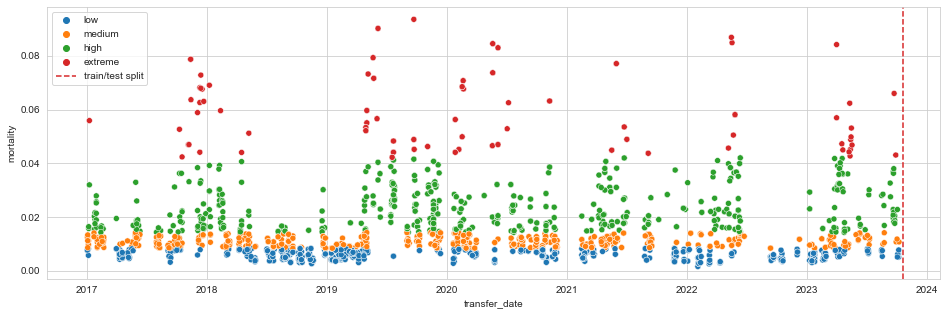

In [204]:
#train_data[['locus_id', 'fish_group_id', 'transfer_date', 'mortality']]
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,5))
sns.scatterplot(data=data_targets, x='transfer_date', y='mortality', hue='target_group', ax=ax)
ax.axvline(threshold_date, ls='--', color='tab:red', label='train/test split')
plt.legend()

In [205]:
# display(train_data.head())
# display(test_data.head())

In [206]:
# train_data['mortality_perc'] = train_data['mortality'] * 100
# train_data['log_mortality'] = np.log(train_data['mortality'])

# test_data['mortality_perc'] = test_data['mortality'] * 100
# test_data['log_mortality'] = np.log(test_data['mortality'])

# targets = ['mortality', 'mortality_perc', 'log_mortality', 'tgc', 'nsfr']

In [1]:
test_min_date = test_data['transfer_date'].min().strftime('%Y-%m-%d')
test_max_date = test_data['transfer_date'].max().strftime('%Y-%m-%d')

NameError: name 'test_data' is not defined

In [208]:
test_min_date, test_max_date

('2017-01-04', '2022-09-22')

C:\Users\dmitrii\AppData\Local\Temp\ipykernel_23488\1184069190.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['input_type'] = 'test'


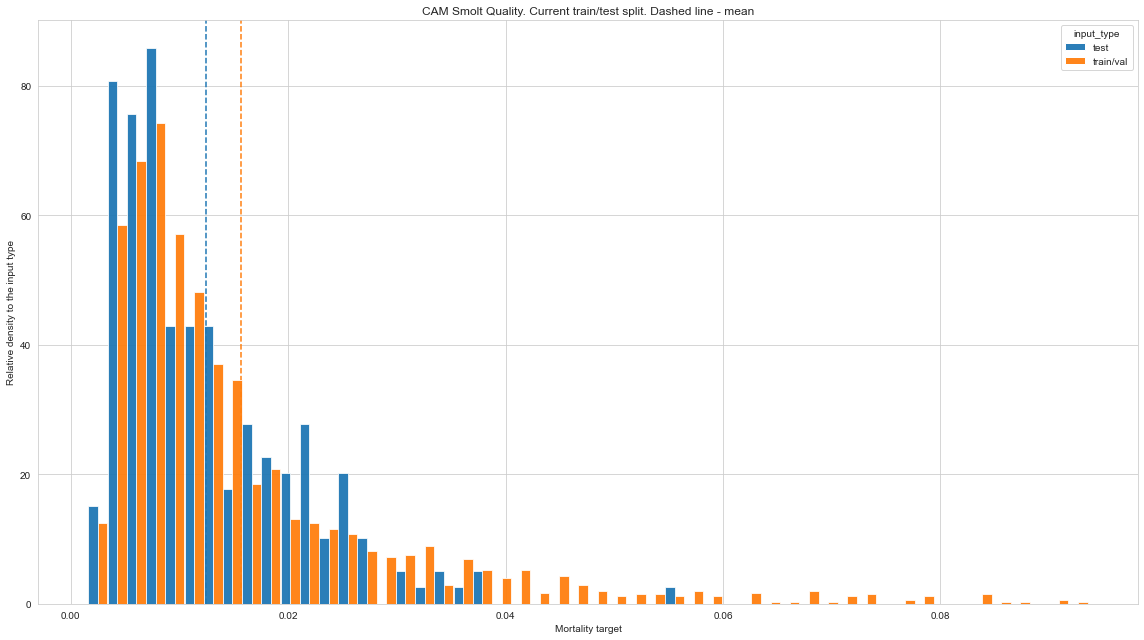

In [221]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(16,9))
n_df = test_data[['mortality']]
n_df['input_type'] = 'test'

n_df = pd.concat([n_df, train_data_scaled[['mortality']]], axis=0)
n_df['input_type'] = n_df['input_type'].fillna('train/val')
#n_df = n_df.reset_index()
ax.axvline(test_data['mortality'].mean(), ls='--', color='tab:blue', label='test mean', zorder=1)
ax.axvline(train_data_scaled['mortality'].mean(), ls='--', color='tab:orange', label='train/val mean', zorder=1)
ax.set_xlabel('Mortality target')
sns.histplot(data=n_df, x='mortality', hue='input_type', multiple="dodge", stat='density', shrink=0.99, alpha=0.95, common_norm=False, ax=ax, zorder=2)
ax.set_ylabel('Relative density to the input type')
ax.set_title('CAM Smolt Quality. Current train/test split. Dashed line - mean')
plt.tight_layout()
plt.savefig('../data/images/train_test.png')

#n_df.pivot_table(index='index', columns='input_type', values='mortality', aggfunc='mean').plot.hist(width=0.1, ax=ax)

In [210]:
def adjusted_smape(y_true, y_pred, epsilon=1e-6):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon
    smape_value = np.mean(np.abs(y_pred - y_true) / denominator) * 100
    return smape_value

In [211]:
features = [f for f in most_relevant_features if f in data_targets.columns]

In [212]:
features

['temperature_fw_sw_diff',
 'atpasa_derivative',
 'number_of_weeks_with_summer_vac_transfer',
 'temperature_cleared-before_first_feeding-mean',
 'is_luf_weighted',
 'fw_cycle_length_first_mvmt_shipout',
 'temperature_cleared-before_first_feeding-degree_days',
 'is_nacl-whole_period-sum',
 'is_nacl-after_first_feeding-sum',
 'mortality_rate-after_first_feeding-sum_Desadaptado']

In [213]:
[f for f in most_relevant_features if f not in data_targets.columns]

[]

In [214]:
res = []
for f in features:
    res.append([f, data_targets.loc[data_targets[f].notna(), 'transfer_date'].max()])
res = pd.DataFrame(res, columns=['feature', 'max_valid_date'])
res.sort_values('max_valid_date')

,feature,max_valid_date
1,atpasa_derivative,2023-05-08
0,temperature_fw_sw_diff,2023-10-08
2,number_of_weeks_with_summer_vac_transfer,2023-10-08
3,temperature_cleared-before_first_feeding-mean,2023-10-08
4,is_luf_weighted,2023-10-08
5,fw_cycle_length_first_mvmt_shipout,2023-10-08
6,temperature_cleared-before_first_feeding-degre...,2023-10-08
7,is_nacl-whole_period-sum,2023-10-08
8,is_nacl-after_first_feeding-sum,2023-10-08
9,mortality_rate-after_first_feeding-sum_Desadap...,2023-10-08


### Train

-0.10386132427229744
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


,smape_acc_train,smape_acc_val,smape_acc_test,train/val_N,test_N,mae,median_true_average_value,median_pred_average_value,std_error
0,92.914852,83.049422,71.933586,1950,224,0.007218,0.00965,0.009569,0.010048


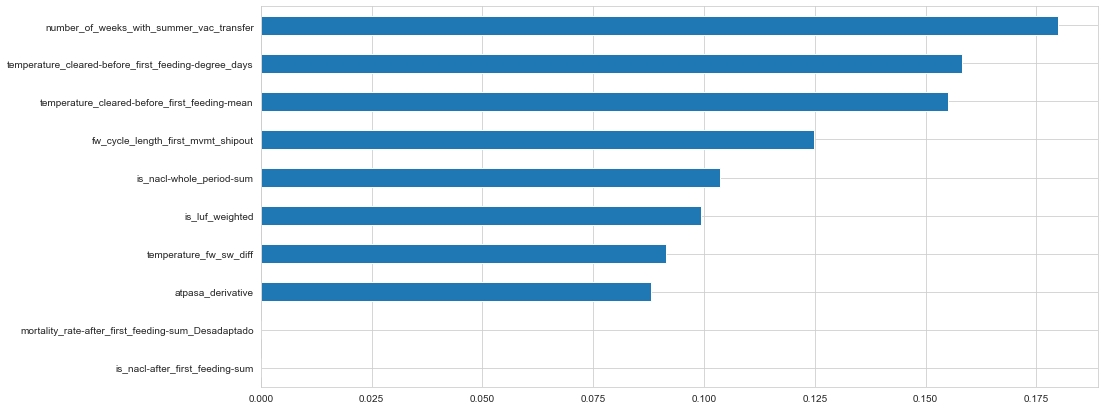

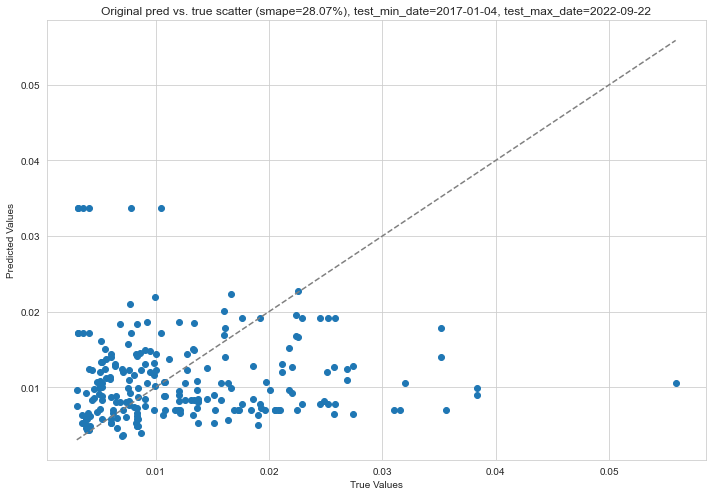

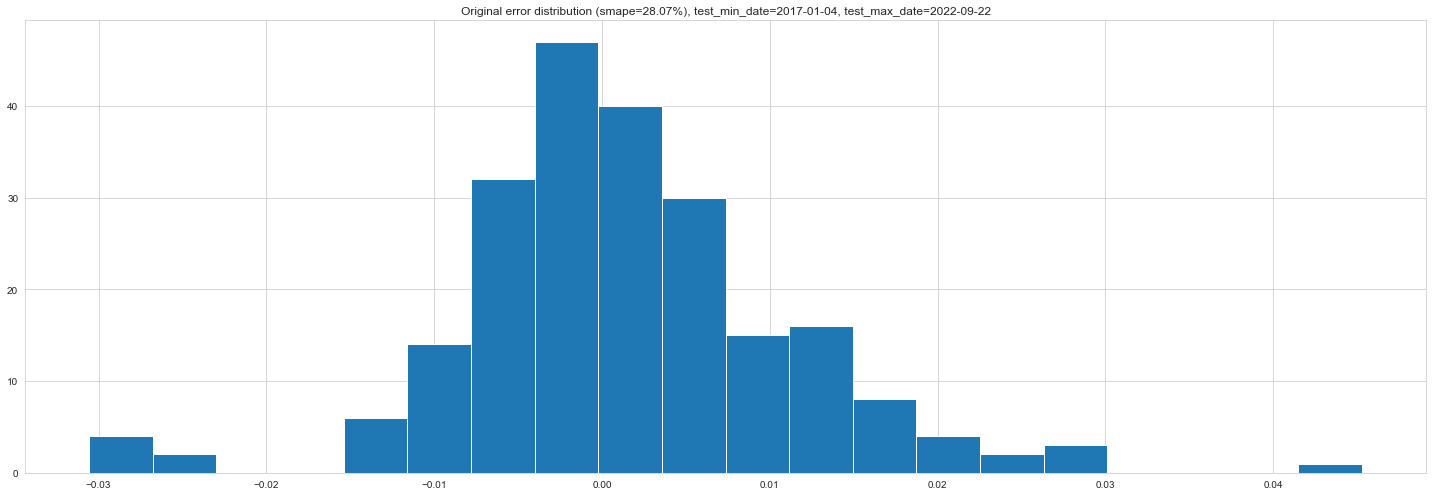

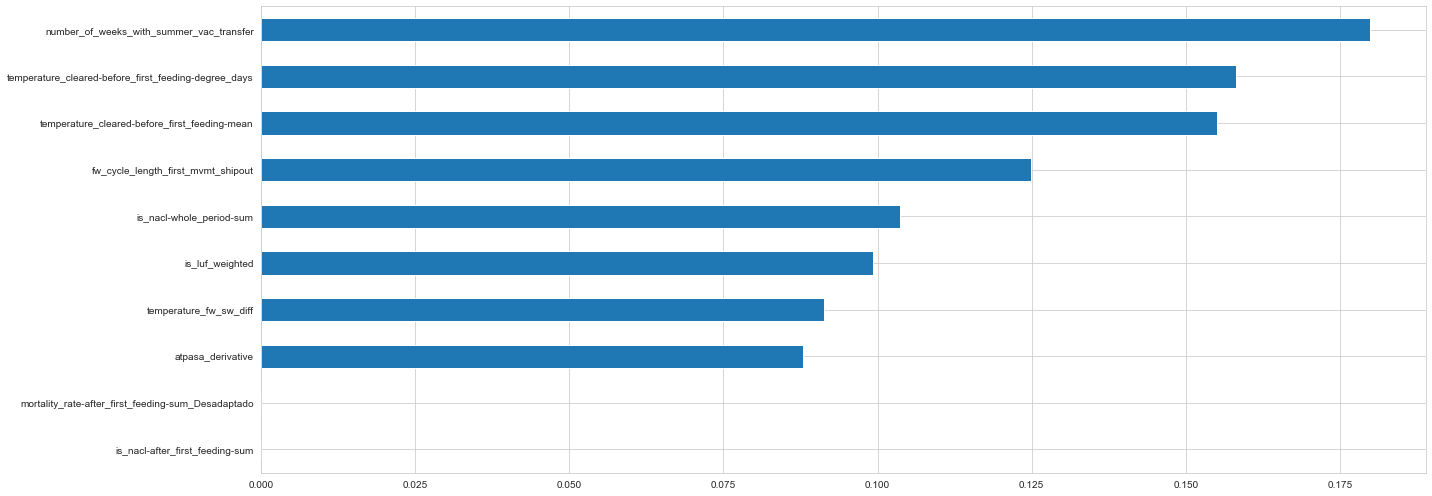

In [220]:
sns.set_style('whitegrid')

data = train_data_scaled.copy()
target = 'log_mortality'
#features = final_features.copy()
# features = final_features_top10.copy()

baseline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
baseline.process()

y_pred = np.exp(baseline.model_best.predict(test_data_scaled[features]))
y_true = test_data['mortality']

#y_pred = baseline.model_best.predict(test_data_scaled[features])
#y_true = test_data['log_mortality']

metrics = {
    'smape_acc_train': 100-baseline.smape_train,
    'smape_acc_val': 100-baseline.smape_val,
    'smape_acc_test': 100-smape(y_true, y_pred),
    'train/val_N': len(data),
    'test_N': len(y_pred),
    'mae': (y_true - y_pred).abs().mean(), #mean_absolute_error(y_true, y_pred),
    #'mape': mape(y_true, y_pred),
    'median_true_average_value': np.median(y_true),
    'median_pred_average_value': np.median(y_pred),
    'std_error': np.std(y_true - y_pred),
}

# y_true_perc = y_true * 100
# y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
# diff_perc = y_true_perc - y_pred_perc

#save_path = img_path / 'predictive' / 'errors'
#save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(10, 7))
# plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%), test_min_date={test_min_date}, test_max_date={test_max_date}")
plt.scatter(x=y_true, y=y_pred)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
fig.savefig(f'../data/images/{target}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%), test_min_date={test_min_date}, test_max_date={test_max_date}")
plt.hist(diff_original, bins=20)
plt.tight_layout()
fig.savefig(f'../data/images/{target}_error_distribution.jpg')

df_metrics = pd.DataFrame(metrics, index=[0])
display(df_metrics)
df_metrics.to_csv(f'../data/images/{target}_model_metrics.csv',index=False)

save_stats(
    baseline,
    save_path='../data/images/',
    img_save_path='../data/images/',
    prefix=target
)

In [216]:
baseline.model_factors.sort_values(ascending=False)

number_of_weeks_with_summer_vac_transfer                0.179875
temperature_cleared-before_first_feeding-degree_days    0.158206
temperature_cleared-before_first_feeding-mean           0.154977
fw_cycle_length_first_mvmt_shipout                      0.124815
is_nacl-whole_period-sum                                0.103582
is_luf_weighted                                         0.099246
temperature_fw_sw_diff                                  0.091331
atpasa_derivative                                       0.087968
is_nacl-after_first_feeding-sum                         0.000000
mortality_rate-after_first_feeding-sum_Desadaptado      0.000000
dtype: float32

In [217]:
latest_pred = np.exp(baseline.model_best.predict(pred_data[features]))
pred_data['prediction'] = latest_pred

In [218]:
pred_data[['fish_group_id', 'locus_id', 'transfer_date', 'prediction']]

,fish_group_id,locus_id,transfer_date,prediction
2005,6973,6407852,2023-10-23,0.007361
2006,6973,6407853,2023-10-23,0.007361
2009,6973,6407854,2023-10-24,0.007361
2010,6973,6407860,2023-10-24,0.007361
2011,6973,6407861,2023-10-25,0.007361
2012,6973,6407862,2023-10-25,0.007361
2013,6973,6407863,2023-10-25,0.007361
2021,6982,7150091,2023-10-30,0.007361
2024,6987,7150092,2023-12-11,0.006900
2027,6982,7150093,2023-10-30,0.007361


In [219]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def confusion_df(true, pred):
    classes = [c for c in BUCKET_LABELS if c in true.unique()]
    cm = confusion_matrix(true, pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    return cm_df

def create_confusion_matrix_and_metrics(true, pred):
    classes = ['low', 'medium', 'high', 'extreme']
    cm = confusion_matrix(true, pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'

    TPs, TNs, FPs, FNs = {}, {}, {}, {}
    F_scores, FPRs = {}, {}

    # Calculate TP, TN, FP, FN, F-score, FPR for each class
    for i, class_name in enumerate(classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum().sum() - (TP + FP + FN)

        TPs[class_name] = TP
        TNs[class_name] = TN
        FPs[class_name] = FP
        FNs[class_name] = FN

        precision, recall, f_score, _ = precision_recall_fscore_support(true, pred, labels=[class_name])
        F_scores[class_name] = f_score[0]
        FPRs[class_name] = FP / (FP + TN) if (FP + TN) != 0 else 0

    metrics_df = pd.DataFrame({
        'TP': TPs, 'TN': TNs, 'FP': FPs, 'FN': FNs,
        'F-score': F_scores, 'FPR': FPRs
    })

    return cm_df, metrics_df

In [ ]:
pred_group = pd.cut(y_pred, labels=BUCKET_LABELS, bins=[0,] + bins).astype(str)
true_group = test_data['target_group'].astype(str)
create_confusion_matrix_and_metrics(true_group, pred_group)